# Test Dropout in a model using some custome dataset


In [10]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


# Pytorch device specific configuration
# Pytorch Gpu Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

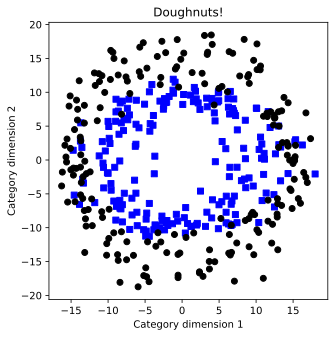

In [ ]:
# Create dataset
nPerCluster = 200

th = np.linspace(0, 4 * np.pi, nPerCluster)
r1 = 10
r2 = 15

# Generate the data
a = [
    r1 * np.cos(th) + np.random.randn(nPerCluster) * 3,
    r1 * np.sin(th) + np.random.randn(nPerCluster),
]
b = [
    r2 * np.cos(th) + np.random.randn(nPerCluster),
    r2 * np.sin(th) + np.random.randn(nPerCluster) * 3,
]

# True Labels
labels_np = np.vstack((np.zeros((nPerCluster, 1)), np.ones((nPerCluster, 1))))

# Concat into a matrix
data_np = np.hstack((a, b)).T

# Convert data_np and labels_np to pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# Show the data
fig = plt.figure(figsize=(5, 5))
plt.plot(
    data[np.where(labels.cpu() == 0)[0], 0].cpu(),
    data[np.where(labels.cpu() == 0)[0], 1].cpu(),
    "bs",
)
plt.plot(
    data[np.where(labels.cpu() == 1)[0], 0].cpu(),
    data[np.where(labels.cpu() == 1)[0], 1].cpu(),
    "ko",
)
plt.title("Doughnuts!")
plt.xlabel("Category dimension 1")
plt.ylabel("Category dimension 2")
plt.show()

In [ ]:
# Separate data into data loders
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2
)

# Convert to pytorch dataset
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Finally Load into datloader object
batchsize = 16
train_loader = DataLoader(
    train_data, batch_size=batchsize, shuffle=True, generator=torch.Generator(device)
)
test_loader = DataLoader(
    test_data,
    batch_size=test_data.tensors[0].shape[0],
    generator=torch.Generator(device),
)

In [ ]:
# Create model class
class theModelClass(nn.Module):
    def __init__(self, dr):
        super().__init__()

        # Layers
        self.input = nn.Linear(2, 128)
        self.hidden = nn.Linear(128, 128)
        self.output = nn.Linear(128, 1)

        # parameters
        self.dr = dr

    # Forward pass
    def forward(self, x):

        # Pass data through input layer
        x = F.relu(self.input(x))

        # Dropout after input layer
        x = F.dropout(
            x, p=self.dr, training=self.training
        )  # self.training will turnoff dropout at eval() mode

        # Pass through the hidden layer
        x = F.relu(self.hidden(x))

        # Dropout after hidden layer
        x = F.dropout(x, p=self.dr, training=self.training)

        # Output Layer
        x = self.output(x)  # There will be no dropout at the output layer

        return x

In [20]:
# Let's check the model for typos
tmpModel = theModelClass(0.2)

# Run through random data
tmpdata = torch.randn((10, 2))
yHat = tmpModel(tmpdata)
yHat

tensor([[ 0.0501],
        [-0.1233],
        [-0.0087],
        [-0.0947],
        [ 0.1304],
        [-0.0661],
        [ 0.0163],
        [-0.1152],
        [ 0.0367],
        [-0.0470]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [22]:
# Function to create and train the model
def createNewModel(dr, lr=0.02):
    ANNModel = theModelClass(dr)

    # Loss Function
    lossFun = nn.BCEWithLogitsLoss()

    # Optimizer
    optimizer = torch.optim.SGD(ANNModel.parameters(), lr=lr)

    return ANNModel, lossFun, optimizer

In [ ]:
# Function to train the model
def trainTheModel(ANNModel, lossFun, optimizer, nEpochs):
    # Initialize accuracies as empties
    trainAcc = []
    testAcc = []
    losses = []

    # Loop over epoches
    for epoch in range(nEpochs):
        # Swithch to training mode
        ANNModel.train()

        # Initialize batch accuracy and loss
        batchAcc = []
        batchLoss = []

        for X, y in train_loader:

            # Forward Pass
            yHat = ANNModel(X)
            loss = lossFun(yHat, y)
            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Comput the batch training accuracy
            batchAcc.append(100 * torch.mean(((yHat > 0) == y).float()).item())
            batchLoss.append(torch.mean(loss).cpu().detach())

        # Training epoch accuracy and loss
        losses.append(np.mean(batchLoss))
        trainAcc.append(np.mean(batchAcc))

        # Test Accuracy
        ANNModel.eval()  # Model evaluation mode on
        X, y = next(iter(test_loader))
        yHat = ANNModel(X)
        testAcc.append(100 * torch.mean(((yHat > 0) == y).float()).item())

    # Function output
    return trainAcc, testAcc, losses

In [30]:
# Test the model
# Define Dropout rate and nEpochs
dr = 0.0
nEpochs = 1000
# Create the model
ANNModel, lossFun, optimizer = createNewModel(dr)

# train the model
trainAcc, testAcc, losses = trainTheModel(ANNModel, lossFun, optimizer, nEpochs)

In [ ]:
# Create 1D smothing filter
def smooth(x, k=5):
    return np.convolve(x, np.ones(k) / k, mode="same")

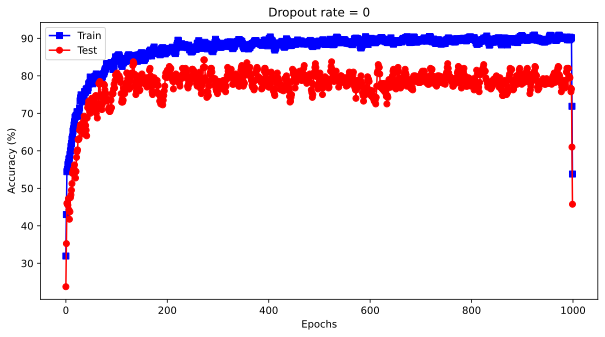

In [36]:
# plot the results
fig = plt.figure(figsize=(10, 5))

plt.plot(smooth(trainAcc), "bs-")
plt.plot(smooth(testAcc), "ro-")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend(["Train", "Test"])
plt.title("Dropout rate = %g" % dr)

plt.show()

### Dropout rate test to find optimal dropout rate

In [37]:
drs = np.arange(10) / 10 # This varies dropout rate between 0 and 1

results = np.zeros((len(drs), 3))

for i in range(len(drs)):

    # Create and train the model
    ANNModel, lossFun, optimizer = createNewModel(drs[i])
    trainAcc, testAcc, losses = trainTheModel(ANNModel, lossFun, optimizer, nEpochs)

    # Store the results
    results[i, 0] = np.mean(trainAcc[-100:])
    results[i, 1] = np.mean(testAcc[-100:])
    results[i, 2] = np.mean(losses)

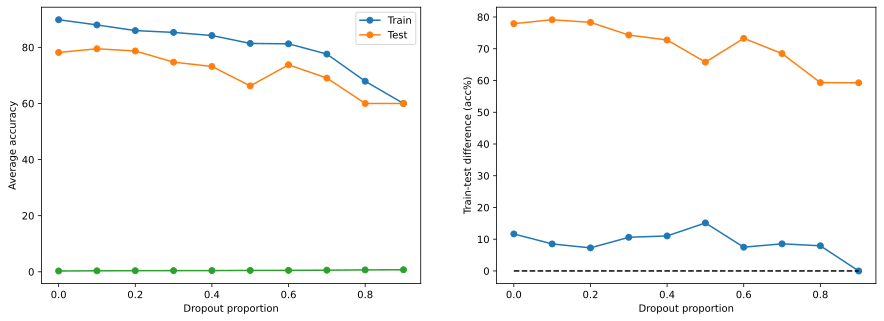

In [38]:
# plot the experiment results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(drs, results, "o-")
ax[0].set_xlabel("Dropout proportion")
ax[0].set_ylabel("Average accuracy")
ax[0].legend(["Train", "Test"])

ax[1].plot(drs, -np.diff(results, axis=1), "o-")
ax[1].plot([0, 0.9], [0, 0], "k--")
ax[1].set_xlabel("Dropout proportion")
ax[1].set_ylabel("Train-test difference (acc%)")

plt.show()